In [1]:
from IPython.core.display import display, HTML

### Widen notebook to fit browser window
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
// Press ctrl-M followed by r to "run all cells" in this notebook

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [3]:
import os, time
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from file_utils import get_img_filenames
from configuration import dict_config_params
from sliding_windows import search_windows, slide_window, draw_boxes
from feature_extracters import extract_features, extract_color_features, extract_hog_features

In [4]:
def fit_svm(X, labels, verbose=True):
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, labels, 
                                                        test_size=0.2, 
                                                        random_state=rand_state) 
    
    # Use a linear SVC 
    svc = LinearSVC()
    
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()

    if verbose:
        print("\n",round(t2-t, 2), 'Seconds to train SVC...')
        print('\nTest Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        
        t=time.time()    
        n_predict = 10
        print('\nMy SVC predicts:     ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print("\n",round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc, X_scaler

In [5]:
def get_training_data():
    
    img_filenames_cars, img_filenames_notcars = get_img_filenames()
    
    truncate_data_at = dict_config_params['truncate_training_data_after']
    
    hog_feat = dict_config_params['use_hog_feat']
    spatial_feat = dict_config_params['use_spatial_feat']
    hist_feat = dict_config_params['use_hist_feat']
    
    ## Feature vectors CAR
    feature_vectors_car = []
    count = 1
    for img_filename in img_filenames_cars:    
        image = mpimg.imread(img_filename)

        img_features = extract_features(image, verbose=False, 
                                    hog_feat=hog_feat, spatial_feat=spatial_feat, hist_feat=hist_feat)
        feature_vectors_car.append(img_features)
        
        if truncate_data_at > 0 and count > truncate_data_at:
            break
        count += 1

    ## Feature vectors NOT-CAR
    feature_vectors_notcar = []
    count = 1
    for img_filename in img_filenames_notcars:    
        image = mpimg.imread(img_filename)

        img_features = extract_features(image, verbose=False, 
                                    hog_feat=hog_feat, spatial_feat=spatial_feat, hist_feat=hist_feat)
        feature_vectors_notcar.append(img_features)
        
        if truncate_data_at > 0 and count > truncate_data_at:
            break
        count += 1


    # Create an array stack of feature vectors
    X = np.vstack((feature_vectors_car, feature_vectors_notcar)).astype(np.float64)                        
    print("len(X): {}".format(len(X)))

    # Define the labels vector
    labels = np.hstack((np.ones(len(feature_vectors_car)), 
                        np.zeros(len(feature_vectors_notcar))))
    
    return X, labels


Using already available cached classifier.

Overwriting cached classifier.


/home.net/rh17dur/miniconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


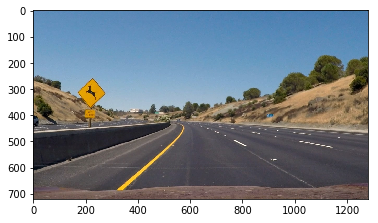

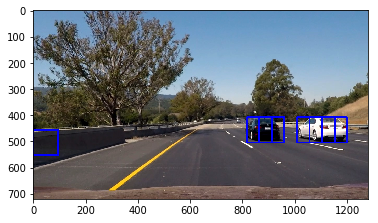

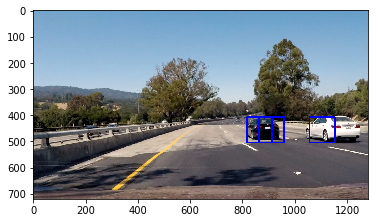

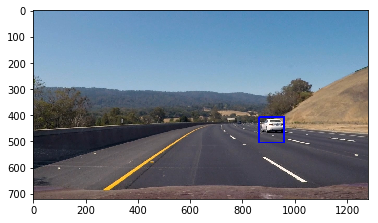

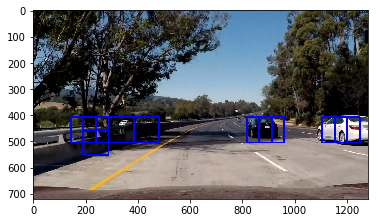

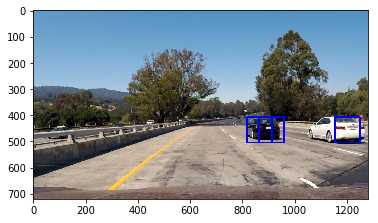

In [7]:
import pickle

def main():

    # Pickle dump classifier
    filename_classifier = "./classifiers_pickle.p"
    if (dict_config_params['use_cached_classifier'] is True and
        os.path.exists(filename_classifier)):
            print("\nUsing already available cached classifier.")
            svc, X_scaler = pickle.load( open(filename_classifier, "rb" ) )
    else:
        X, labels = get_training_data()    
        svc, X_scaler = fit_svm(X, labels, verbose=True)
        
    if dict_config_params['overwrite_cached_classifier']:
        print("\nOverwriting cached classifier.")
        pickle.dump([svc, X_scaler], open( filename_classifier, "wb" ) )
    
    # Test images    
    count_fig = 1
    filenames_img = glob.glob('./test_images/test*.jpg')
    for filename_img in filenames_img:
        image = mpimg.imread(filename_img)
        draw_image = np.copy(image)

        # Normalize image intensity, since we read in a jpg
        image = image.astype(np.float32)/255

        y_start_stop = [np.int(image.shape[0]/2), image.shape[0] - 60]
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

        hot_windows = search_windows(image, windows, svc, X_scaler)                       
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

        #print("window_img.shape {}".format(window_img))
        plt.figure(count_fig)
        plt.imshow(window_img)
        count_fig += 1
    
    plt.show()
    
if __name__ == '__main__':
    main()